# Matplotlib and pylab inline

In [3]:
%matplotlib inline
%pylab inline

Populating the interactive namespace from numpy and matplotlib


# Import libraries

In [43]:
import os
import cv2 as cv
import matplotlib.pyplot as plt

from matplotlib import rcParams
from modules.reading import *
from modules.standardization import standardize_image
from modules.preprocessing import preproc_image
from modules.mask_and_contour import get_mask
from pandas import DataFrame
rcParams["figure.dpi"] = 100
rcParams["figure.figsize"] = (4, 5)
rcParams["image.cmap"] = "gray"

## Read image

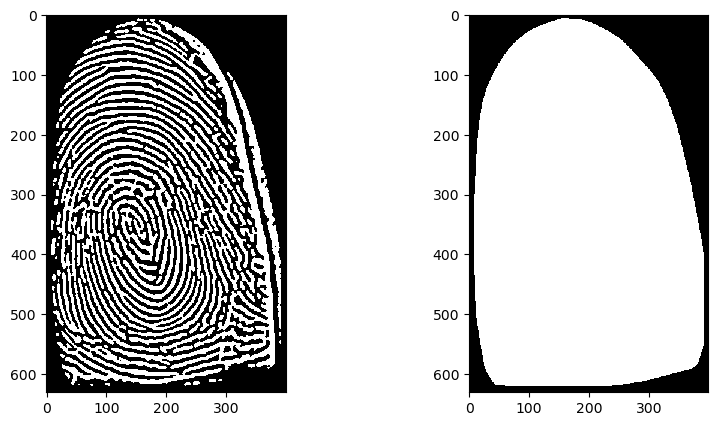

In [15]:
im = read_random_image(RAW_FILE_PATH_GOODIM)
std_im = standardize_image(im)
prep_im = preproc_image(std_im)
mask = get_mask(prep_im, with_ench=False) == 255

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

ax1.imshow(prep_im)
ax2.imshow(mask)
plt.show()

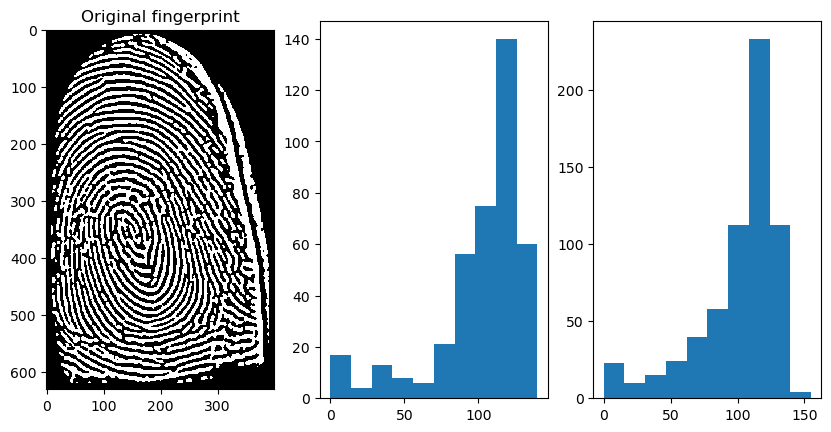

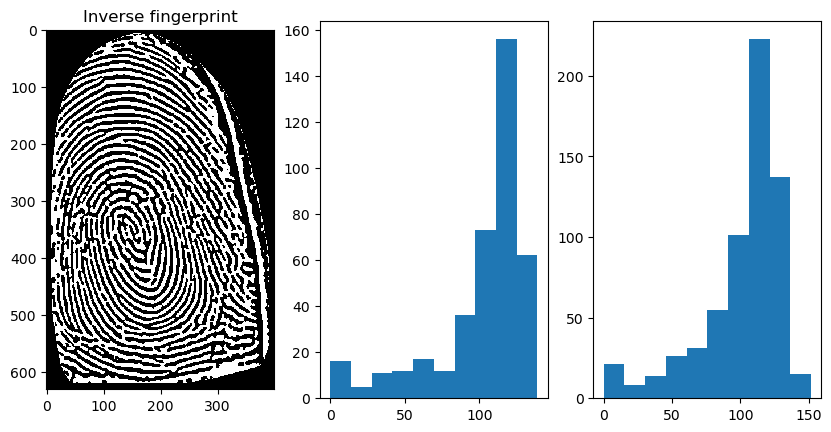

In [24]:
inv_im = cv.bitwise_not(prep_im)
inv_im[mask ==False] = 0

orig_v_sum, orig_h_sum = prep_im.mean(axis=0), prep_im.mean(axis=1)
inv_v_sum, inv_h_sum = inv_im.mean(axis=0), inv_im.mean(axis=1)

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(10, 5))

ax1.imshow(prep_im)
ax1.set_title("Original fingerprint")
ax2.hist(orig_v_sum)
ax3.hist(orig_h_sum)
plt.show()

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(10, 5))

ax1.imshow(inv_im)
ax1.set_title("Inverse fingerprint")
ax2.hist(inv_v_sum)
ax3.hist(inv_h_sum)
plt.show()

In [56]:
def get_horizontal_vertical_mean_percentiles(im, percs=[30, 60, 90, 100]):
    result = np.array([])
    mask = get_mask(im, with_ench=False)
    
    inv_im = cv.bitwise_not(im)
    inv_im[mask ==False] = 0

    orig_v_sum = np.percentile(im.mean(axis=0), percs)
    orig_h_sum = np.percentile(im.mean(axis=1), percs)
    inv_v_sum = np.percentile(inv_im.mean(axis=0), percs) 
    inv_h_sum = np.percentile(inv_im.mean(axis=1), percs)
    result = np.append(result, [orig_h_sum, orig_v_sum, inv_h_sum, inv_v_sum])
    
    return result

In [57]:
get_horizontal_vertical_mean_percentiles(prep_im)

array([ 96.2625    , 116.6625    , 127.5       , 154.9125    ,
        96.9889065 , 115.98256735, 127.70206022, 139.82567353,
        96.9       , 115.3875    , 127.5       , 151.725     ,
       102.64659271, 116.79080824, 127.74247227, 139.01743265])

# Use Linear SVC for image classification

## Function for getting data

In [58]:
def get_xy_ims(filepath, images, x, y, y_val=1):
    
    for name in os.listdir(filepath):
        path = filepath + name
        im = cv.imread(path, cv.IMREAD_GRAYSCALE)
        
        if path == None:
            continue
        
        std_im = standardize_image(im)
        prep_im = preproc_image(std_im)
        percentiles = get_horizontal_vertical_mean_percentiles(prep_im)

        images.append(prep_im)
        x.append(percentiles)
        y.append(y_val)
    

## Get data

In [59]:
images, x, y = [], [], []


get_xy_ims(RAW_FILE_PATH_GOODIM, images, x, y)
get_xy_ims(RAW_FILE_PATH_BADIM_HOLES, images, x, y, y_val=0)

images = np.array(images)
x = np.array(x)
y = np.array(y)

DataFrame(x)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
0,98.87625,117.3000,136.4250,172.7625,103.278997,119.106583,127.500000,156.277429,100.72500,117.3000,134.51250,182.3250,104.078370,119.106583,126.340909,161.073668
1,99.51375,117.9375,128.1375,145.9875,99.076433,116.536624,131.966561,189.625796,96.26250,114.1125,124.31250,156.8250,97.452229,116.130573,129.976911,184.347134
2,97.53750,115.3875,133.8750,168.9375,103.355072,117.850242,125.652174,131.811594,100.08750,118.5750,134.51250,189.9750,108.693237,121.135266,128.526570,137.971014
3,105.06000,115.3875,124.3125,166.3875,103.281005,117.852433,132.143642,151.318681,105.06000,121.7625,131.96250,161.9250,106.483516,117.692308,130.942700,148.516484
4,96.90000,114.1125,131.3250,165.1125,98.817734,115.566502,127.290640,138.177340,96.51750,116.6625,134.51250,161.9250,102.628079,115.985222,126.871921,138.596059
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
67,30.60000,58.0125,90.5250,146.6250,35.107535,56.043956,86.227630,134.905808,154.91250,182.3250,196.98750,205.2750,140.950549,193.912088,225.777080,231.381476
68,81.60000,103.9125,121.7625,135.7875,74.741379,112.471787,125.501567,132.695925,92.50125,118.0650,139.16625,175.3125,99.002351,120.305643,132.296238,141.888715
69,108.37500,121.1250,138.9750,182.9625,102.080063,123.296703,142.551805,163.328100,102.51000,119.8500,133.87500,204.6375,102.360283,116.491366,131.703297,159.725275
70,81.60000,93.7125,106.9725,130.6875,72.390995,100.710900,126.492891,161.137441,130.68750,144.0750,159.37500,194.4375,110.258294,136.966825,198.279621,215.924171


## Train LinearSVC and get

In [60]:
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score

svc = LinearSVC(max_iter=5000000)
svc.fit(x, y)

predict = svc.predict(x)
bool_predict = predict != y


for im, good, percs in zip(images[bool_predict], y[bool_predict], x[bool_predict]):
    
    if good:
        print("Является хорошим, считается плохим", percs)
    else:
        print("Является плохим, считается хорошим", percs)
    
    plt.imshow(im, cmap=plt.cm.gray)
    plt.show()

## There is no mistake predictions